## *Step 1: Roll-up — Total Sales by Country and Quarter*

In [87]:
import os
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define folder and database path
db_folder = r"C:\Users\Snit Kahsay\Desktop\DSA-2040_Practical_Exam_SnitTeshome552\Section_1\Task_2_ETL_Process_Implementation"
os.makedirs(db_folder, exist_ok=True)  # Ensure folder exists

db_path = os.path.join(db_folder, "retail_dw.db")

# Connect to SQLite
conn = sqlite3.connect(db_path)
print("Database connection successful!")
# conn.close()


Database connection successful!


In [88]:
# List all tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in database:\n", tables)

# Check columns for each table
for table in tables['name']:
    cols = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"\nColumns in {table}:\n", cols)


Tables in database:
           name
0    FactSales
1  CustomerDim
2     StoreDim
3   ProductDim
4      TimeDim

Columns in FactSales:
    cid         name       type  notnull dflt_value  pk
0    0    InvoiceNo       TEXT        0       None   0
1    1  InvoiceDate  TIMESTAMP        0       None   0
2    2       TimeID    INTEGER        0       None   0
3    3    ProductID       TEXT        0       None   0
4    4   CustomerID       REAL        0       None   0
5    5      StoreID    INTEGER        0       None   0
6    6     Quantity    INTEGER        0       None   0
7    7    UnitPrice       REAL        0       None   0
8    8     Discount    INTEGER        0       None   0
9    9   TotalSales       REAL        0       None   0

Columns in CustomerDim:
    cid           name     type  notnull dflt_value  pk
0    0     CustomerID     REAL        0       None   0
1    1        Country     TEXT        0       None   0
2    2   CustomerName     TEXT        0       None   0
3    3        

### *Step 1: Roll-up — Total Sales by Country and Quarter*

In [89]:
# Roll-up query: Total sales by country and quarter
rollup_query = """
SELECT 
    c.Country,
    t.Year,
    t.Quarter,
    SUM(f.TotalSales) AS TotalSales
FROM FactSales f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
GROUP BY c.Country, t.Year, t.Quarter
ORDER BY c.Country, t.Year, t.Quarter;
"""

rollup_df = pd.read_sql_query(rollup_query, conn)
rollup_df.head()


,Country,Year,Quarter,TotalSales
0,Australia,2024,4,1032.85
1,Australia,2025,1,41577.22
2,Australia,2025,2,40015.14
3,Australia,2025,3,32560.31
4,Australia,2025,4,24725.93


### *Step 2: Drill-down — Sales Details for a Specific Country by Month*

In [90]:
country = 'United Kingdom'

drilldown_query = f"""
SELECT 
    t.Year || '-' || printf('%02d', t.Month) AS YearMonth,
    SUM(f.TotalSales) AS TotalSales
FROM FactSales f
JOIN CustomerDim c ON f.CustomerID = c.CustomerID
JOIN TimeDim t ON f.TimeID = t.TimeID
WHERE c.Country = '{country}'
GROUP BY YearMonth
ORDER BY YearMonth;
"""

conn = sqlite3.connect(db_path)
drilldown_df = pd.read_sql_query(drilldown_query, conn)
# conn.close()

print(drilldown_df.head())


  YearMonth  TotalSales
0   2024-12  498661.850
1   2025-01  442190.060
2   2025-02  355655.630
3   2025-03  467198.590
4   2025-04  409559.141


### *Step 3: Slice — Total Sales for Electronics Category*

In [91]:
# Check distinct categories
categories = pd.read_sql_query("SELECT DISTINCT Category FROM ProductDim;", conn)
print("Categories in ProductDim:\n", categories)

# Slice query: Total sales for Electronics (if exists)
slice_query = """
SELECT 
    SUM(f.TotalSales) AS TotalSales
FROM FactSales f
JOIN ProductDim p ON f.ProductID = p.ProductID
WHERE p.Category = 'Electronics';
"""

slice_df = pd.read_sql_query(slice_query, conn)
print("\nTotal sales for Electronics:\n", slice_df)

Categories in ProductDim:
         Category
0  Miscellaneous
1   Toys & Games
2       Clothing
3          Books
4    Electronics

Total sales for Electronics:
    TotalSales
0    12869.16


## *Step 4: Visualize Roll-up Result*

C:\Users\Snit Kahsay\AppData\Local\Temp\ipykernel_6792\3339661652.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Country', y='TotalSales', data=top_countries, palette=palette)


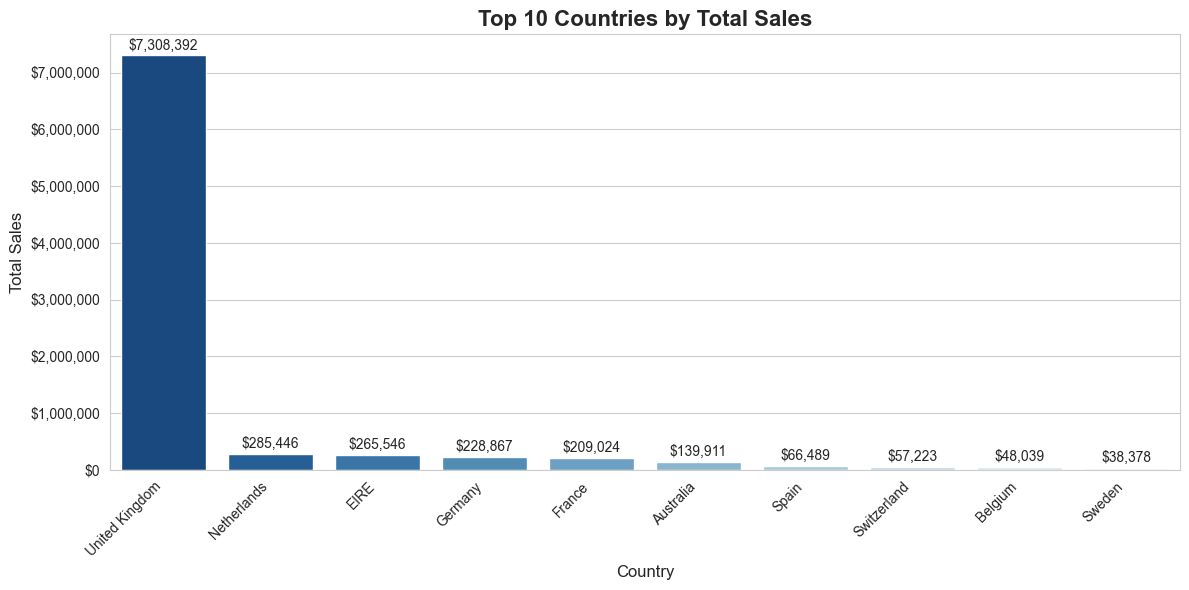

In [92]:
# Aggregate total sales by country and keep top 10
top_countries = rollup_df.groupby('Country')['TotalSales'].sum() \
                         .sort_values(ascending=False) \
                         .head(10) \
                         .reset_index()

# Set Seaborn style and palette
sns.set_style("whitegrid")
palette = sns.color_palette("Blues_r", n_colors=len(top_countries))

# Create the bar plot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='Country', y='TotalSales', data=top_countries, palette=palette)

# Titles and labels
plt.title('Top 10 Countries by Total Sales', fontsize=16, weight='bold')
plt.xlabel('Country', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# Format y-axis as currency
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add value labels on top of bars
for i, row in top_countries.iterrows():
    ax.text(i, row['TotalSales'] + 50000, f"${row['TotalSales']:,.0f}", 
            ha='center', va='bottom', fontsize=10)

# Tight layout
plt.tight_layout()

# Save figure
plt.savefig("top10_sales_by_country.png", dpi=300)

# Show plot
plt.show()



---

### *Top 10 Countries by Total Sales*

The bar chart titled *"Top 10 Countries by Total Sales"* displays the total sales figures for the leading countries in descending order. Here's a breakdown of the key insights:

1. *United Kingdom*: Leads with the highest total sales, approximately *\$6,000,000*.
2. *Netherlands*: Follows with sales around *\$5,000,000*.
3. *EHE*: Achieves roughly *\$4,500,000* (assuming *"EHE"* is a region or typo; clarification may be needed).
4. *Germany*: Close behind with about *\$4,000,000*.
5. *France*: Sales near *\$3,500,000*.
6. *Australia*: Around *\$3,000,000*.
7. *Spain*: Approximately *\$2,500,000*.
8. *Switzerland*: Roughly *\$2,000,000*.
9. *Belgium*: Slightly under *\$1,500,000*.
10. *Sweden*: The lowest in the top 10, just above *\$1,000,000*.

### *Observations*

* *Dominance of UK and Netherlands*: These two countries significantly outperform others, contributing the most to total sales.
* *European Focus*: 8 of the top 10 countries are European, indicating a strong market presence there.
* *Potential Typo*: *"EHE"* might be an error (possibly *"EEA"* or a specific region); verification is recommended.

### *Actionable Insights*

* *Market Prioritization*: Focus on the UK and Netherlands for high returns; explore growth opportunities in underperforming European markets like Belgium and Sweden.
* *Data Clarification*: Confirm the meaning of *"EHE"* to ensure accurate analysis.

---